In [2]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../src")
import xgboost as xgb

# from imblearn.over_sampling import SMOTE, ADASYN
import pandas as pd
import numpy as np

from features.UserJoin import (
    UserJoin,
    submit,
    diff,
    plt_month,
    plt_day,
    load_ids,
    info,
    infot,
    f1score,
    gen_day_hol_n,
)

import config as C
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
from xgboost import plot_tree, plot_importance
import random
from pathlib import Path

import warnings

warnings.filterwarnings("ignore")

from tqdm import tqdm
import itertools

sns.set_style("ticks", {"axes.grid": True})

pd.options.display.max_columns = 500
# pd.options.display.max_rows = 20
# pd.options.display.min_rows = 20
plt.style.use("ggplot")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [3]:
ds = UserJoin()

# Feature Columns

In [4]:
except_col = [
    "   ",
    "ELEC_TYPE_NAME",
    # "VOLT_NAME",
    "PRC_NAME",
    "CONTRACT_CAP",
    "RUN_CAP",
    "SHIFT_NO",
    "BUILD_DATE",
    "CANCEL_DATE",
    "CHK_CYCLE",
    "LAST_CHK_DATE",
    "TMP_NAME",
    "TMP_DATE",
    "IS_FLAG",
]

day_feature_cv_col = [
    "kwh_holiday_cv",
    "kwh_cal_holiday_cv",
    "kwh_pap_r2_holiday_cv",
    "kwh_pap_r3_holiday_cv",
    "kwh_pap_r4_holiday_cv",
    "kwh_workday_cv",
    "kwh_cal_workday_cv",
    "kwh_pap_r2_workday_cv",
    "kwh_pap_r3_workday_cv",
    "kwh_pap_r4_workday_cv",
    "kwh_cv",
    "kwh_cal_cv",
    "kwh_pap_r2_cv",
    "kwh_pap_r3_cv",
    "kwh_pap_r4_cv",
]
# 每个节假日各自算的各特征的 cv 后均值
hol_cv_col = [
    # "cv1_all",
    "cv2_all",
    "cv3_all",
    "cv4_all",
    "cv_all",
    # "cv1_holiday",
    "cv2_holiday",
    "cv3_holiday",
    "cv4_holiday",
    "cv_holiday",
    # "cv1_workday",
    "cv2_workday",
    "cv3_workday",
    "cv4_workday",
    "cv_workday",
]

# 节假日平均和非节假日平均的差值。
hol_diff_col = [
    "kwh_holiday_diff",
    "kwh_cal_holiday_diff",
    "kwh_pap_r2_holiday_diff",
    "kwh_pap_r3_holiday_diff",
    "kwh_pap_r4_holiday_diff",
    "pr2_holiday_diff",
    "pr3_holiday_diff",
    "pr4_holiday_diff",
    "2_3_holiday_diff",
    "2_4_holiday_diff",
    "3_4_holiday_diff",
    "daycv_holiday_diff",
]

# 节假日均值 和 非节假日的均值
hol_mean_col = [
    "kwh_holiday_mean_1",
    "kwh_cal_holiday_mean_1",
    "kwh_pap_r2_holiday_mean_1",
    "kwh_pap_r3_holiday_mean_1",
    "kwh_pap_r4_holiday_mean_1",
    "pr2_holiday_mean_1",
    "pr3_holiday_mean_1",
    "pr4_holiday_mean_1",
    "2_3_holiday_mean_1",
    "2_4_holiday_mean_1",
    "3_4_holiday_mean_1",
    "daycv_holiday_mean_1",
    "kwh_holiday_mean_0",
    "kwh_cal_holiday_mean_0",
    "kwh_pap_r2_holiday_mean_0",
    "kwh_pap_r3_holiday_mean_0",
    "kwh_pap_r4_holiday_mean_0",
    "pr2_holiday_mean_0",
    "pr3_holiday_mean_0",
    "pr4_holiday_mean_0",
    "2_3_holiday_mean_0",
    "2_4_holiday_mean_0",
    "3_4_holiday_mean_0",
    "daycv_holiday_mean_0",
]

# 节假日方差 和 非节假日的方差
hol_std_col = [
    "kwh_holiday_std_1",
    "kwh_cal_holiday_std_1",
    "kwh_pap_r2_holiday_std_1",
    "kwh_pap_r3_holiday_std_1",
    "kwh_pap_r4_holiday_std_1",
    "pr2_holiday_std_1",
    "pr3_holiday_std_1",
    "pr4_holiday_std_1",
    "2_3_holiday_std_1",
    "2_4_holiday_std_1",
    "3_4_holiday_std_1",
    "daycv_holiday_std_1",
    "kwh_holiday_std_0",
    "kwh_cal_holiday_std_0",
    "kwh_pap_r2_holiday_std_0",
    "kwh_pap_r3_holiday_std_0",
    "kwh_pap_r4_holiday_std_0",
    "pr2_holiday_std_0",
    "pr3_holiday_std_0",
    "pr4_holiday_std_0",
    "2_3_holiday_std_0",
    "2_4_holiday_std_0",
    "3_4_holiday_std_0",
    "daycv_holiday_std_0",
]

# 日基础数据
day_col = [
    "kwh",
    "kwh_cal",
    "kwh_pap_r2",
    "kwh_pap_r3",
    "kwh_pap_r4",
    "pr2",
    "pr3",
    "pr4",
    "2_3",
    "2_4",
    "3_4",
    "daycv",
]

user_col = [
    "ELEC_TYPE_NAME",
    "VOLT_NAME",
    "RUN_CAP",
    # 'ELEC_TYPE_NAME_CODE',
    # 'VOLT_NAME_CODE',
    # 'label'
]

month_col = [
    "pq_f",
    "pq_g",
    "pq_p",
    "pq_z",
    "pp",
    "pf",
    "pg",
    "p_f",
    "p_g",
    "f_g",
    "monthcv",
]

all_col = (
    hol_diff_col
    + hol_mean_col
    + hol_std_col
    + day_col
    + user_col
    + month_col
    + hol_cv_col
    + day_feature_cv_col
)

In [5]:
def train_both(df, cols, params):
    pred, model = train(df, cols, params)
    # pred_aug, model_aug = train(df, cols, params, aug=True)
    pred_aug, model_aug = None, None

    return pred, model, pred_aug, model_aug


def preprocess(df, cols, aug):
    if "ELEC_TYPE_NAME" in cols:
        df = pd.concat([df, pd.get_dummies(df.ELEC_TYPE_NAME)], axis=1).drop(
            columns=["ELEC_TYPE_NAME"]
        )
    if "VOLT_NAME" in cols:
        df = pd.concat([df, pd.get_dummies(df.VOLT_NAME)], axis=1).drop(
            columns=["VOLT_NAME"]
        )

    features = [i for i in cols if i not in ["ELEC_TYPE_NAME", "VOLT_NAME"]]
    x, x_val = (
        df.loc[df.label != "test", features],
        df.loc[df.label == "test", features],
    )
    y = df.loc[df.label != "test", "label"].astype("int")

    if aug:
        x, y = SMOTE().fit_resample(x, y)
        # x, y = ADASYN().fit_resample(x, y)
    return x, x_val, y


def train(df, cols, params, aug=False):
    x, x_val, y = preprocess(df, cols, aug)
    print(x.shape)

    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", **params)
    model.fit(x, y)

    pred_val = pd.DataFrame({"id": x_val.index.values, "label": model.predict(x_val)})
    return pred_val, model


def score(ids):
    if type(ids) != set:
        ids = set(ids)
    print(
        f"{len(ids)} \
            \t right: {len(ids & C.true_ids)} \
            \t wrong: {len(ids & C.false_ids)} \
            \t unknown: {len(ids - C.true_ids - C.false_ids)} \
            \nf1score: {f1score(ids)}"
    )
    true = len(ids & C.true_ids)
    false = len(ids & C.false_ids)
    unknown = len(ids) - true - false
    if unknown == 0:
        print("official:", score_official(true, false))
    else:
        print(
            f"official: {score_official(true, false+unknown):.3f} ->  {score_official(min(true + unknown, 37), false):.3f}"
        )


def score_official(right, wrong):
    true_num = 37
    y_true = np.zeros(15379)
    y_pred = np.zeros(15379)
    y_true[:true_num] = 1
    y_pred[:right] = 1
    if wrong:
        y_pred[-wrong:] = 1
    score = f1_score(y_true, y_pred, average="macro")
    return score

In [6]:
score_official(35, 0)

0.9860785229601627

# Model 1 - 单独用月数据做训练
每个用户对应22个月，将22个月看做22个用户。他们有各自的 label。

In [7]:
df1 = ds.month
# df1 = df1[df1.index.isin(ds.train2.index.values)]
# feature1 = C.month_features + ["VOLT_NAME"]
feature1 = C.month_features
pred1, model1, pred_aug1, model_aug1 = train_both(df1, feature1, {})

(185640, 11)


In [8]:
pred1 = pred1.groupby("id").sum()
ids1 = set(pred1[pred1.label > 8].index.values)
score(ids1)

34             	 right: 27             	 wrong: 7             	 unknown: 0             
f1score: 0.826890756302521
official: 0.8800046998843847


# Model 2 - 月数据平均后做训练

In [9]:
def is_feature(i):
    if i in ["label", "isminer"]:
        return False
    if "kwh" in i or "day" in i:
        return False
    if i in except_col:
        return False
    return True


df2 = ds.train
feature2 = list(filter(is_feature, df2.columns))
pred2, model2, pred_aug2, model_aug2 = train_both(df2, feature2, {})

(8840, 21)


In [10]:
pred2 = pred2.groupby("id").sum()
ids2 = set(pred2.query("label == 1").index.values)
score(ids2)

36             	 right: 25             	 wrong: 11             	 unknown: 0             
f1score: 0.7651326699834162
official: 0.8420909774754968


# Model 3 - 单独用日数据做训练
每个用户108天，看做108个用户，有各自的label（这个肯定不如后边想到的方法好。新方法还没实现，先把这个训练好放在这）

In [11]:
df3 = ds.day
feature3 = C.day_features
pred3, model3, pred_aug3, model_aug3 = train_both(df3, feature3, {})

(945730, 12)


In [12]:
pred3 = pred3.groupby("id").sum()
ids3 = set(pred3.query(f"label > 30").index.values)
score(ids3)

42             	 right: 23             	 wrong: 13             	 unknown: 6             
f1score: 0.7224295190713101
official: 0.791 ->  0.867


# Model 4 - 日数据平均后做训练

In [13]:
def is_feature(i):
    if i in ["label", "isminer"]:
        return False
    if (
        "pq" in i
        or "month" in i
        or "pr" in i
        or i in ["pp", "pr", "pg", "pf", "p_f", "f_g", "p_g"]
    ):
        return False
    if i in except_col:
        return False
    # if "kwh" in i or "hol" in i:
    # return False
    return True


df4 = ds.train
feature4 = list(filter(is_feature, df4.columns))
pred4, model4, pred_aug4, model_aug4 = train_both(df4, feature4, {})
# feature4

(8840, 81)


In [14]:
pred4 = pred4.groupby("id").sum()
ids4 = set(pred4.query("label == 1").index.values)
score(ids4)

31             	 right: 23             	 wrong: 7             	 unknown: 1             
f1score: 0.777056277056277
official: 0.838 ->  0.853


# Model 5 - 单独用日数据做训练（升级版）
每个用户108天，分布在12个节假日，看做12个用户。

In [15]:
mean_std_cols = [
    "kwh_pap_r2",
    "kwh_pap_r3",
    "kwh_pap_r4",
    "kwh_cal",
    "pr2",
    "pr3",
    "pr4",
    "2_3",
    "2_4",
    "3_4",
    "daycv",
]


def zip_df_holiday(df):
    return [
        (df, "allday"),
        (df.query("type == 0"), "holiday"),
        (df.query("type != 0"), "workday"),
    ]


def groupby_user_holiday_cv(df):
    cols = ["kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4", "kwh_cal"]

    holcvs = [
        (
            dfi.groupby(["id", "hol_n"])[cols].std()
            / (dfi.groupby(["id", "hol_n"])[cols].mean() + 1e-5)
        ).rename(
            columns={col: f"{prefix}_{col.replace('kwh_pap', 'cv')}" for col in cols}
        )
        for dfi, prefix in zip_df_holiday(df)
    ]
    return pd.concat(
        holcvs,
        axis=1,
    )


def groupby_user_holiday_mean(df):
    means = [
        dfi.groupby(["id", "hol_n"])[mean_std_cols]
        .mean()
        .rename(columns={col: f"{prefix}_mean_{col}" for col in mean_std_cols})
        for dfi, prefix in zip_df_holiday(df)
    ]
    return pd.concat(
        means,
        axis=1,
    )


def groupby_user_holiday_std(df):
    stds = [
        dfi.groupby(["id", "hol_n"])[mean_std_cols]
        .std()
        .rename(columns={col: f"{prefix}_std_{col}" for col in mean_std_cols})
        for dfi, prefix in zip_df_holiday(df)
    ]
    return pd.concat(
        stds,
        axis=1,
    )


def day_split_by_holiday(df):
    df["hol_n"] = gen_day_hol_n(df)

    holcv = groupby_user_holiday_cv(df)
    mean = groupby_user_holiday_mean(df)
    std = groupby_user_holiday_std(df)

    return pd.concat([holcv, mean, std], axis=1).dropna()


holiday_df = day_split_by_holiday(ds.day)

In [16]:
def add_label(df):
    df["label"] = "test"
    df.loc[
        df.index.get_level_values(0).isin(
            ds.train.query("label == '0'").index.unique()
        ),
        "label",
    ] = "0"
    df.loc[
        df.index.get_level_values(0).isin(
            ds.train.query("label == '1'").index.unique()
        ),
        "label",
    ] = "1"
    return df


holiday_df = add_label(holiday_df)

In [17]:
df5 = holiday_df
feature5 = [i for i in holiday_df.columns if i != "label"]
pred5, model5, pred_aug5, model_aug5 = train_both(df5, feature5, {})
# feature5

(106065, 78)


In [18]:
pred5["id_"] = pred5.id.map(lambda x: x[0])
ids5 = set(pred5.groupby("id_").sum().query("label > 2").index.values)
score(ids5)

76             	 right: 34             	 wrong: 31             	 unknown: 11             
f1score: 0.6794908062234795
official: 0.800 ->  0.852


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

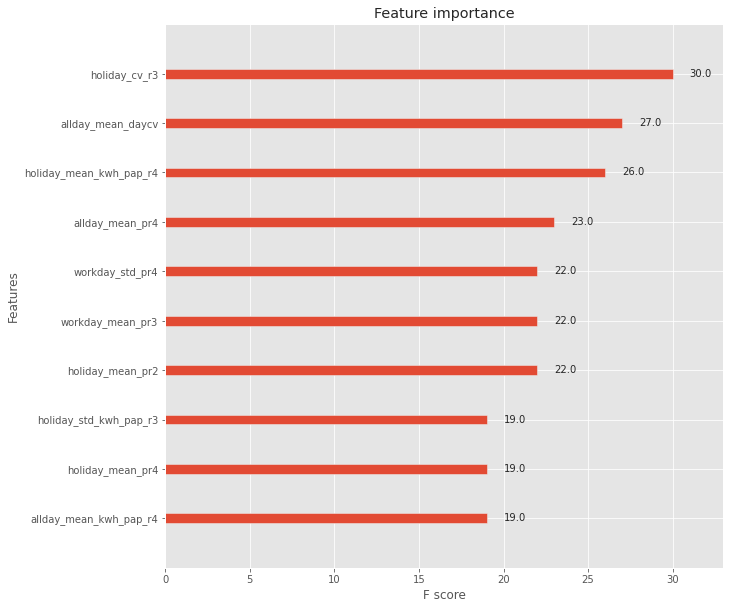

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(model5, max_num_features=10, ax=ax)